In [1]:
import os
from math import sqrt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import csv

This section is used to load the images. Change the directories (lines 32 and 33) to your directories

In [2]:
class SuperResDataset(Dataset):
    def __init__(self, lr_folder, hr_folder, transform=None):
        self.lr_folder = lr_folder
        self.hr_folder = hr_folder
        self.transform = transform

        self.lr_images = os.listdir(lr_folder)
        self.hr_images = os.listdir(hr_folder)

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, index):
        lr_image_path = os.path.join(self.lr_folder, self.lr_images[index])
        hr_image_path = os.path.join(self.hr_folder, self.hr_images[index])

        lr_image = Image.open(lr_image_path).convert('RGB')
        hr_image = Image.open(hr_image_path).convert('RGB')

        if self.transform is not None:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor()
    ])

# Load the dataset
dataset = SuperResDataset(r'E:\GitHub Game Engine Optimisation\08-DLSS\frame_captures_128_128',
                          r'E:\GitHub Game Engine Optimisation\08-DLSS\frame_captures_256_256', transform=transform)

# Create the DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, drop_last=True, shuffle=True)

The images are put into batches of four images, let's take a look at a chunk

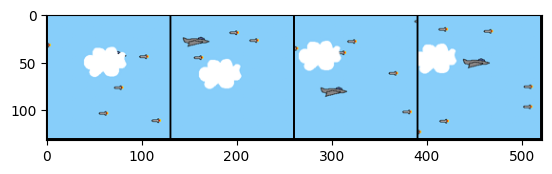

In [3]:
dataiter = iter(dataloader)
images, _ = next(dataiter)

def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

And let's check that the our dataset contains 3 channel (colour images) and low and high resolution images

In [4]:
print(dataset[2][0].shape)
print(dataset[2][1].shape)

torch.Size([3, 128, 128])
torch.Size([3, 256, 256])


We can take a look at a certain image close-up. Note the axis range is different.

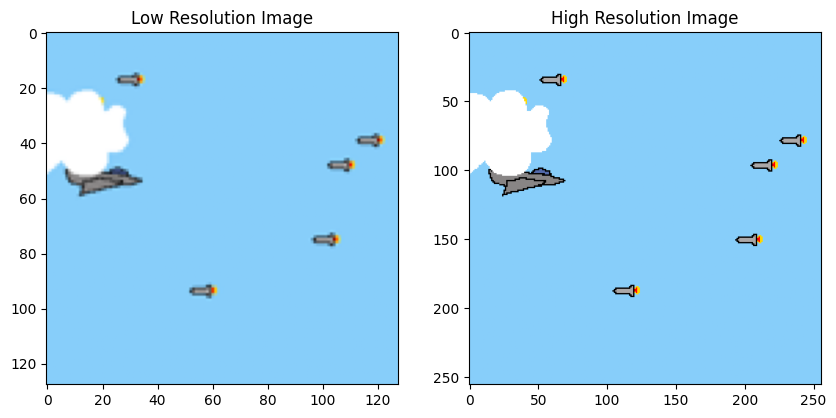

In [5]:
index = 99      # you can change this

transpose = (1, 2, 0)
low_res_example = np.transpose(dataset[index][0], transpose)
high_res_example = np.transpose(dataset[index][1], transpose)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(low_res_example)
ax[0].set_title('Low Resolution Image')
ax[1].imshow(high_res_example)
ax[1].set_title('High Resolution Image')
plt.show()

This is the architecture for the Deep Learning Super Resolution model. It's named the Fast Super-Resolution Convolutional Neural Network (FSRCNN) model and this is the paper it was published in: https://arxiv.org/abs/1608.00367. It's called this because it is designed to be lightweight, so images can be passed through it quickly, making it ideal for AI upscaling video game frames in real-time.

In [6]:
class Model(nn.Module):
    def __init__(self, upscale_factor):
        super().__init__()
        # 1 FEATURE EXTRACTION
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=56, kernel_size=5, stride=1, padding=2),
            nn.PReLU(56))

        # 2 SHRINKING
        self.shrinking = nn.Sequential(
            nn.Conv2d(in_channels=56, out_channels=12, kernel_size=1, stride=1, padding=0),
            nn.PReLU(12))

        # 3 NON-LINEAR MAPPING
        self.mapping = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.PReLU(12),
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.PReLU(12),
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.PReLU(12),
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.PReLU(12),
        )

        # 4 EXPANDING
        self.expanding = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=56, kernel_size=1),
            nn.PReLU(56)
        )

        # 5 DECONVOLUTION
        self.deconvolution = nn.ConvTranspose2d(in_channels=56, out_channels=3, kernel_size=9, stride=upscale_factor, padding=4, output_padding=upscale_factor-1)

        # WEIGHT INITIALISATION
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #print(f'0 Input:              {x.shape}')
        x = self.feature_extraction(x)
        #print(f'1 Feature Extraction: {x.shape}')
        x = self.shrinking(x)
        #print(f'2 Shrinking:          {x.shape}')
        x = self.mapping(x)
        #print(f'2 Non-linear Mapping: {x.shape}')
        x = self.expanding(x)
        #print(f'4 Expanding:          {x.shape}')
        x = self.deconvolution(x)
        #print(f'5 Output:             {x.shape}')
        return x

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=sqrt(2 / (m.out_channels * m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)

        nn.init.normal_(self.deconvolution.weight.data, mean=0.0, std=0.001)
        nn.init.zeros_(self.deconvolution.bias.data)

We need to define some parameters for our training loop, like for how long it will train for.

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
upscale_factor = 2
model = Model(upscale_factor).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.96)   # every 100 epochs
num_epochs = 2000
best_loss = float('inf')
losses = []
model.train()

Model(
  (feature_extraction): Sequential(
    (0): Conv2d(3, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=56)
  )
  (shrinking): Sequential(
    (0): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=12)
  )
  (mapping): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=12)
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=12)
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): PReLU(num_parameters=12)
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): PReLU(num_parameters=12)
  )
  (expanding): Sequential(
    (0): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=56)
  )
  (deconvolution): ConvTranspose2d(56, 3, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4), output_padding=(1, 1))
)

Now we have made an AI model, but it is not trained, so we have to train it! Before this, let's quickly get an output from the model by passing a low resolution image into it and viewing the output. The output will be non-sense at this stage.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


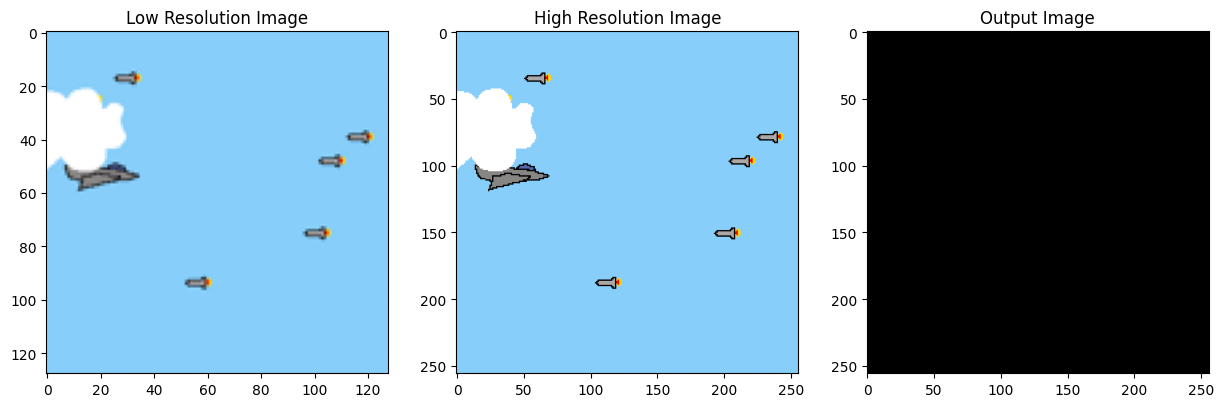

In [11]:
index = 99      # you can change this. It will also be used to display the image at this index during training

def show_images(index):
    transpose = (1, 2, 0)
    low_res_example = np.transpose(dataset[index][0], transpose)
    high_res_example = np.transpose(dataset[index][1], transpose)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Don't compute gradients
        output = model(dataset[index][0].unsqueeze(0).to(device))
    model.train()
    
    output = output.squeeze(0).cpu()
    output = output.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))
    ax[0].imshow(low_res_example)
    ax[0].set_title('Low Resolution Image')
    ax[1].imshow(high_res_example)
    ax[1].set_title('High Resolution Image')
    ax[2].imshow(output)
    ax[2].set_title('Output Image')
    plt.show()
    plt.close()

show_images(index)

Let's train. The results, like above, will be displayed every 100 epochs (an epoch completes every time the whole dataset has been passed through the model). We will also save our model periodically too or if it is the best one. A value called Loss indicates the difference between the actual high resolution and the high resolution the model outputs, so the lower this is the better. This whole process will take ~~fucking ages~~ maybe an hour and a half, but you can stop training early if the outputs are good enough.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/2000], LR: 0.001, Loss: 0.002983848564326763


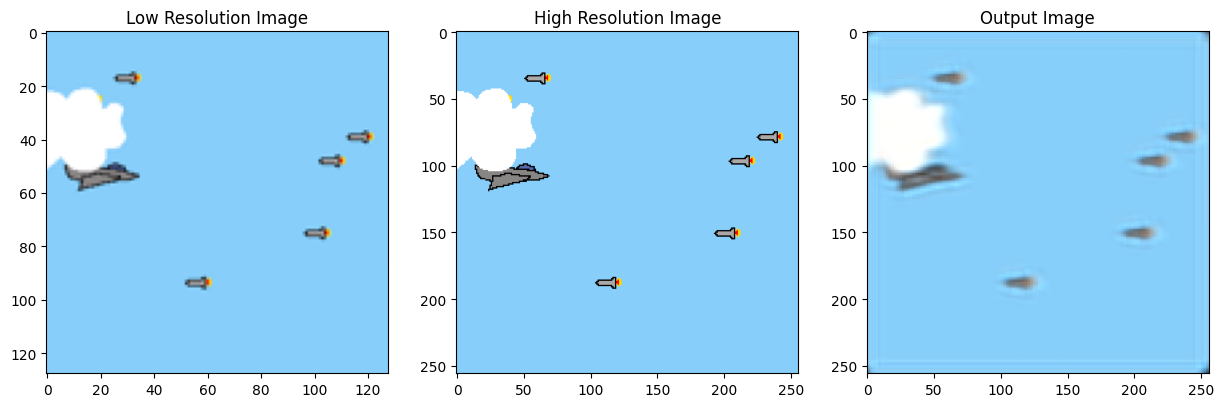

Epoch [2/2000], LR: 0.001, Loss: 0.0022676466032862663
Epoch [3/2000], LR: 0.001, Loss: 0.0018493224633857608
Epoch [4/2000], LR: 0.001, Loss: 0.0015971221728250384
Epoch [5/2000], LR: 0.001, Loss: 0.0014702982734888792
Epoch [6/2000], LR: 0.001, Loss: 0.0013999565271660686
Epoch [7/2000], LR: 0.001, Loss: 0.0027339719235897064
Epoch [8/2000], LR: 0.001, Loss: 0.0009226691909134388
Epoch [9/2000], LR: 0.001, Loss: 0.0011050153989344835
Epoch [10/2000], LR: 0.001, Loss: 0.0009679856593720615
Epoch [11/2000], LR: 0.001, Loss: 0.0008725150255486369
Epoch [12/2000], LR: 0.001, Loss: 0.0008636500569991767
Epoch [13/2000], LR: 0.001, Loss: 0.0008855611085891724
Epoch [14/2000], LR: 0.001, Loss: 0.0011244113557040691
Epoch [15/2000], LR: 0.001, Loss: 0.0005346335237845778
Epoch [16/2000], LR: 0.001, Loss: 0.0006306762807071209
Epoch [17/2000], LR: 0.001, Loss: 0.0005106391618028283
Epoch [18/2000], LR: 0.001, Loss: 0.004996851086616516
Epoch [19/2000], LR: 0.001, Loss: 0.0019870554096996784
E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [100/2000], LR: 0.001, Loss: 0.00030452245846390724


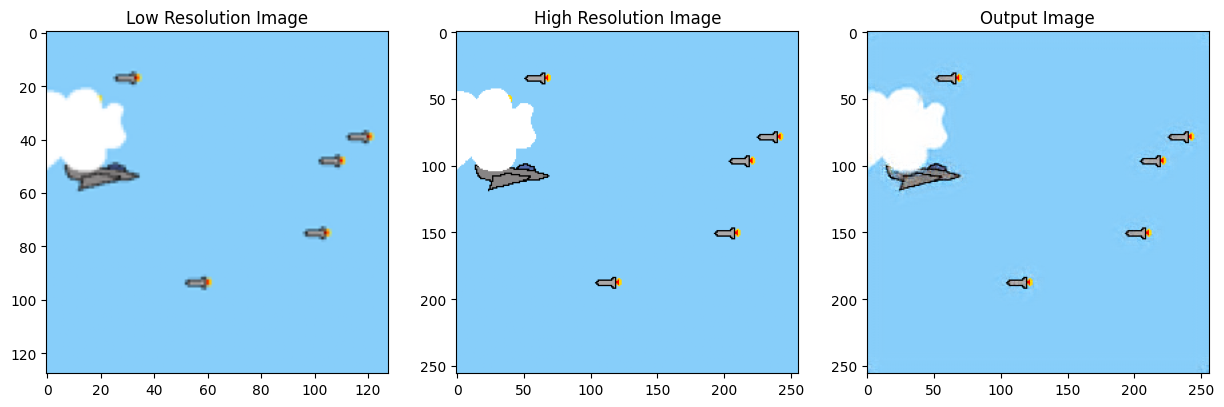

Epoch [101/2000], LR: 0.001, Loss: 0.00031159157515503466
Epoch [102/2000], LR: 0.001, Loss: 0.0003322465345263481
Epoch [103/2000], LR: 0.001, Loss: 0.0003615609311964363
Epoch [104/2000], LR: 0.001, Loss: 0.000259995402302593
Epoch [105/2000], LR: 0.001, Loss: 0.000287174538243562
Epoch [106/2000], LR: 0.001, Loss: 0.0002200238814111799
Epoch [107/2000], LR: 0.001, Loss: 0.00022505514789372683
Epoch [108/2000], LR: 0.001, Loss: 0.00019090092973783612
Epoch [109/2000], LR: 0.001, Loss: 0.00021721671510022134
Epoch [110/2000], LR: 0.001, Loss: 0.00019575613259803504
Epoch [111/2000], LR: 0.001, Loss: 0.00014364962407853454
Epoch [112/2000], LR: 0.001, Loss: 0.0002317051257705316
Epoch [113/2000], LR: 0.001, Loss: 0.023092856630682945
Epoch [114/2000], LR: 0.001, Loss: 0.0008743579383008182
Epoch [115/2000], LR: 0.001, Loss: 0.0007512292359024286
Epoch [116/2000], LR: 0.001, Loss: 0.0005317832110449672
Epoch [117/2000], LR: 0.001, Loss: 0.0003856109397020191
Epoch [118/2000], LR: 0.001,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [200/2000], LR: 0.001, Loss: 0.00013021289487369359


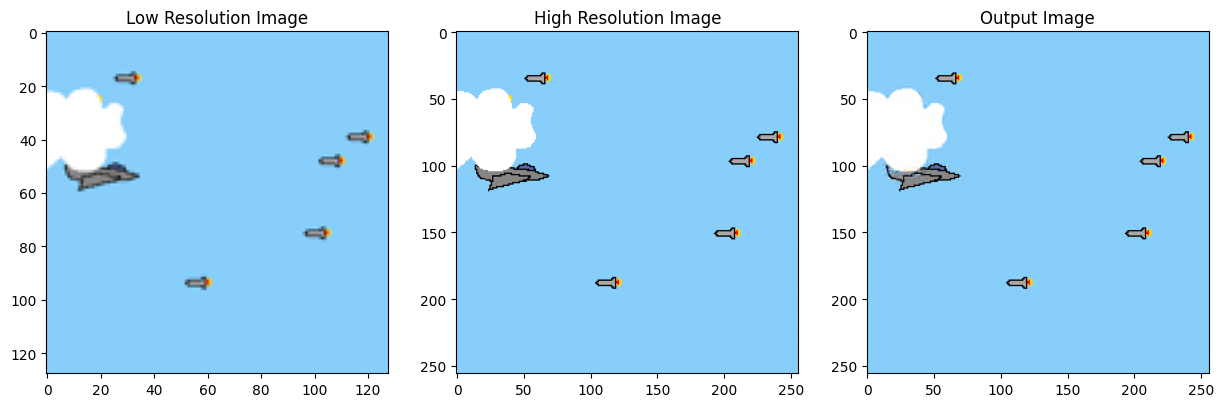

Epoch [201/2000], LR: 0.001, Loss: 8.799204078968614e-05
Epoch [202/2000], LR: 0.001, Loss: 0.00018589191313367337
Epoch [203/2000], LR: 0.001, Loss: 0.00013321090955287218
Epoch [204/2000], LR: 0.001, Loss: 0.00010176938667427748
Epoch [205/2000], LR: 0.001, Loss: 0.0001237189135281369
Epoch [206/2000], LR: 0.001, Loss: 9.05919005163014e-05
Epoch [207/2000], LR: 0.001, Loss: 7.61311239330098e-05
Epoch [208/2000], LR: 0.001, Loss: 0.0001351222163066268
Epoch [209/2000], LR: 0.001, Loss: 0.00011305711086606607
Epoch [210/2000], LR: 0.001, Loss: 9.106942161452025e-05
Epoch [211/2000], LR: 0.001, Loss: 7.046754762995988e-05
Epoch [212/2000], LR: 0.001, Loss: 8.920548134483397e-05
Epoch [213/2000], LR: 0.001, Loss: 8.288175740744919e-05
Epoch [214/2000], LR: 0.001, Loss: 8.0834623076953e-05
Epoch [215/2000], LR: 0.001, Loss: 8.691752736922354e-05
Epoch [216/2000], LR: 0.001, Loss: 9.49081004364416e-05
Epoch [217/2000], LR: 0.001, Loss: 7.922945951577276e-05
Epoch [218/2000], LR: 0.001, Los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [300/2000], LR: 0.001, Loss: 6.478736031567678e-05


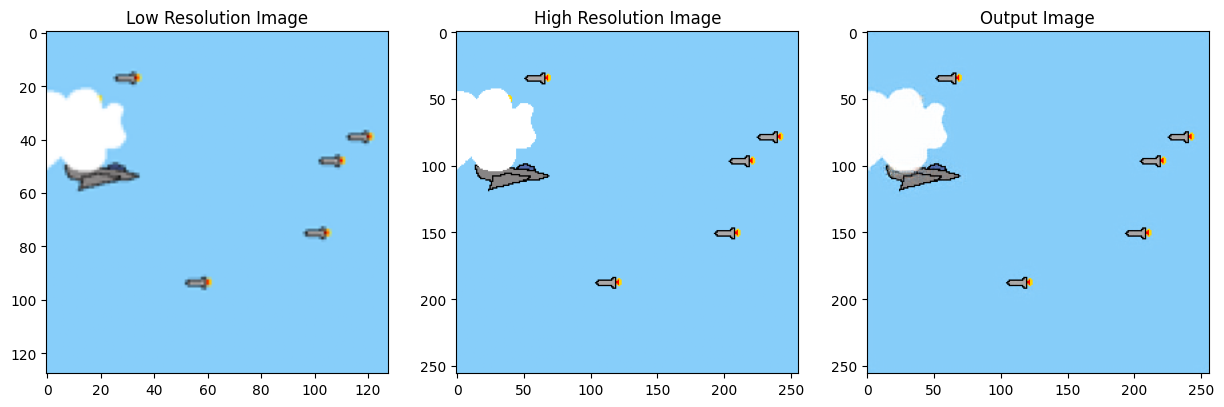

Epoch [301/2000], LR: 0.001, Loss: 6.955261051189154e-05
Epoch [302/2000], LR: 0.001, Loss: 7.450146949850023e-05
Epoch [303/2000], LR: 0.001, Loss: 7.764670590404421e-05
Epoch [304/2000], LR: 0.001, Loss: 4.5533972297562286e-05
Epoch [305/2000], LR: 0.001, Loss: 5.3969222790328786e-05
Epoch [306/2000], LR: 0.001, Loss: 8.515801164321601e-05
Epoch [307/2000], LR: 0.001, Loss: 5.907516970182769e-05
Epoch [308/2000], LR: 0.001, Loss: 9.564158972352743e-05
Epoch [309/2000], LR: 0.001, Loss: 5.650481762131676e-05
Epoch [310/2000], LR: 0.001, Loss: 7.384562923107296e-05
Epoch [311/2000], LR: 0.001, Loss: 8.570090722059831e-05
Epoch [312/2000], LR: 0.001, Loss: 0.00010272245708620176
Epoch [313/2000], LR: 0.001, Loss: 4.146394712734036e-05
Epoch [314/2000], LR: 0.001, Loss: 5.032957415096462e-05
Epoch [315/2000], LR: 0.001, Loss: 4.0179569623433053e-05
Epoch [316/2000], LR: 0.001, Loss: 4.718530544778332e-05
Epoch [317/2000], LR: 0.001, Loss: 6.465616752393544e-05
Epoch [318/2000], LR: 0.001

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [400/2000], LR: 0.001, Loss: 4.948679998051375e-05


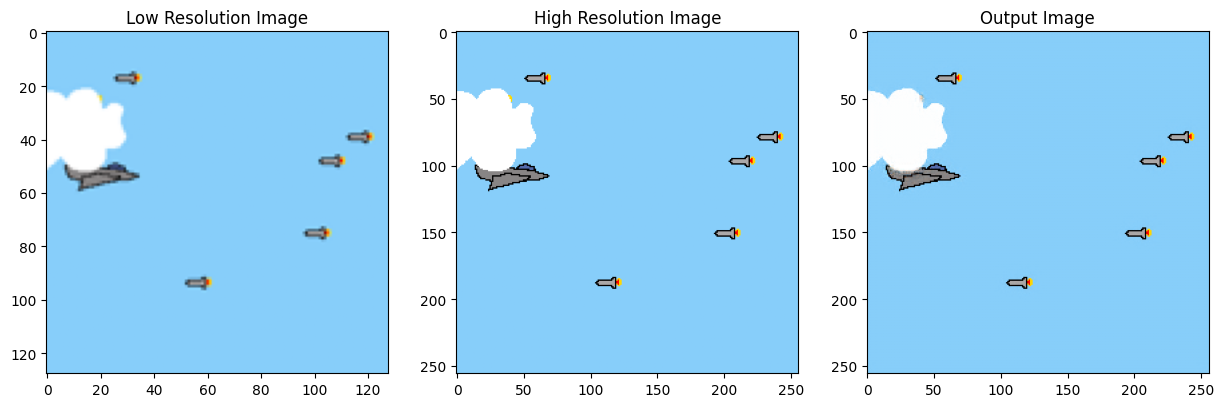

Epoch [401/2000], LR: 0.001, Loss: 1.5622301361872815e-05
Epoch [402/2000], LR: 0.001, Loss: 1.9378692741156556e-05
Epoch [403/2000], LR: 0.001, Loss: 3.819624180323444e-05
Epoch [404/2000], LR: 0.001, Loss: 5.701082409359515e-05
Epoch [405/2000], LR: 0.001, Loss: 2.5987825210904703e-05
Epoch [406/2000], LR: 0.001, Loss: 3.801037382800132e-05
Epoch [407/2000], LR: 0.001, Loss: 5.405046249506995e-05
Epoch [408/2000], LR: 0.001, Loss: 3.3316086046397686e-05
Epoch [409/2000], LR: 0.001, Loss: 2.4877042960724793e-05
Epoch [410/2000], LR: 0.001, Loss: 3.165630187140778e-05
Epoch [411/2000], LR: 0.001, Loss: 3.31788687617518e-05
Epoch [412/2000], LR: 0.001, Loss: 2.054637843684759e-05
Epoch [413/2000], LR: 0.001, Loss: 1.648100260354113e-05
Epoch [414/2000], LR: 0.001, Loss: 2.1428360923891887e-05
Epoch [415/2000], LR: 0.001, Loss: 5.06018077430781e-05
Epoch [416/2000], LR: 0.001, Loss: 3.4133714507333934e-05
Epoch [417/2000], LR: 0.001, Loss: 6.113546260166913e-05
Epoch [418/2000], LR: 0.00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [500/2000], LR: 0.001, Loss: 6.095870048739016e-05


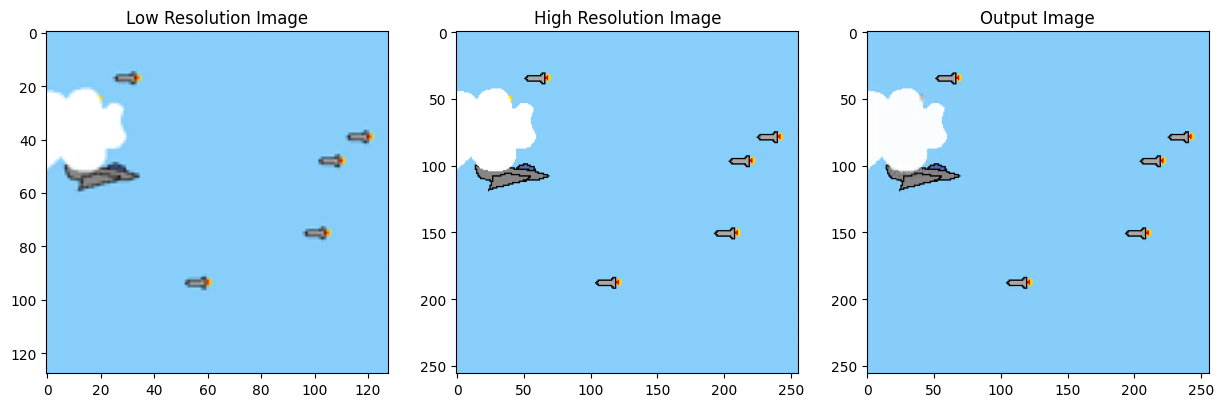

Epoch [501/2000], LR: 0.00096, Loss: 1.6304851669701748e-05
Epoch [502/2000], LR: 0.00096, Loss: 4.390801768749952e-05
Epoch [503/2000], LR: 0.00096, Loss: 4.088127025170252e-05
Epoch [504/2000], LR: 0.00096, Loss: 4.2061110434588045e-05
Epoch [505/2000], LR: 0.00096, Loss: 3.0162264010868967e-05
Epoch [506/2000], LR: 0.00096, Loss: 2.673577910172753e-05
Epoch [507/2000], LR: 0.00096, Loss: 1.5237760635500308e-05
Epoch [508/2000], LR: 0.00096, Loss: 2.6892565074376762e-05
Epoch [509/2000], LR: 0.00096, Loss: 2.1316707716323435e-05
Epoch [510/2000], LR: 0.00096, Loss: 2.4821338229230605e-05
Epoch [511/2000], LR: 0.00096, Loss: 1.3538658095058054e-05
Epoch [512/2000], LR: 0.00096, Loss: 4.623745917342603e-05
Epoch [513/2000], LR: 0.00096, Loss: 2.7090143703389913e-05
Epoch [514/2000], LR: 0.00096, Loss: 4.9242546083405614e-05
Epoch [515/2000], LR: 0.00096, Loss: 1.5302655810955912e-05
Epoch [516/2000], LR: 0.00096, Loss: 2.6758161766338162e-05
Epoch [517/2000], LR: 0.00096, Loss: 2.80401

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [600/2000], LR: 0.00096, Loss: 1.7227484931936488e-05


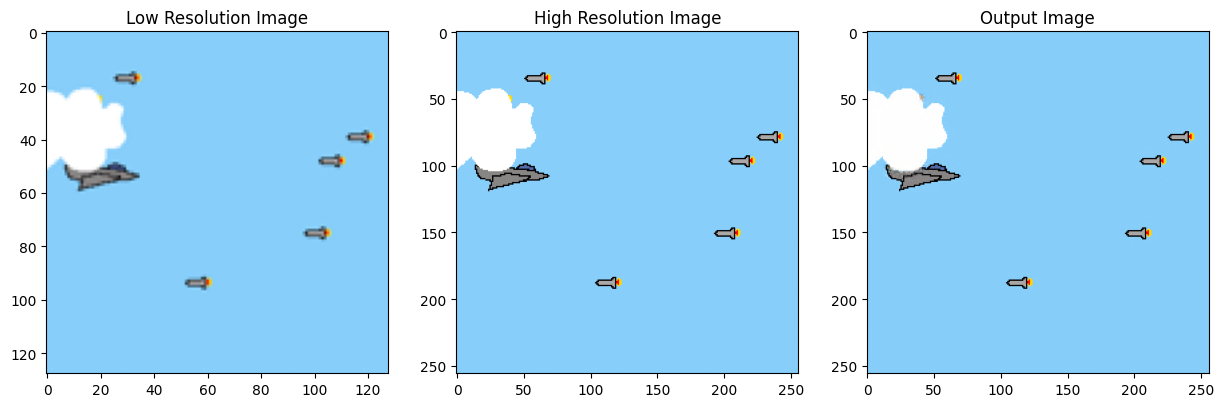

Epoch [601/2000], LR: 0.00096, Loss: 2.257503911096137e-05
Epoch [602/2000], LR: 0.00096, Loss: 2.086396125378087e-05
Epoch [603/2000], LR: 0.00096, Loss: 1.0824813216459006e-05
Epoch [604/2000], LR: 0.00096, Loss: 2.2538448320119642e-05
Epoch [605/2000], LR: 0.00096, Loss: 1.354328378511127e-05
Epoch [606/2000], LR: 0.00096, Loss: 2.7377973310649395e-05
Epoch [607/2000], LR: 0.00096, Loss: 1.708168383629527e-05
Epoch [608/2000], LR: 0.00096, Loss: 3.57795761374291e-05
Epoch [609/2000], LR: 0.00096, Loss: 4.445408922038041e-05
Epoch [610/2000], LR: 0.00096, Loss: 4.128437285544351e-05
Epoch [611/2000], LR: 0.00096, Loss: 1.3208344171289355e-05
Epoch [612/2000], LR: 0.00096, Loss: 8.504845027346164e-06
Epoch [613/2000], LR: 0.00096, Loss: 2.611516356409993e-05
Epoch [614/2000], LR: 0.00096, Loss: 1.5610534319421276e-05
Epoch [615/2000], LR: 0.00096, Loss: 2.061311352008488e-05
Epoch [616/2000], LR: 0.00096, Loss: 2.1344741981010884e-05
Epoch [617/2000], LR: 0.00096, Loss: 2.782552110147

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [700/2000], LR: 0.00096, Loss: 1.831237386795692e-05


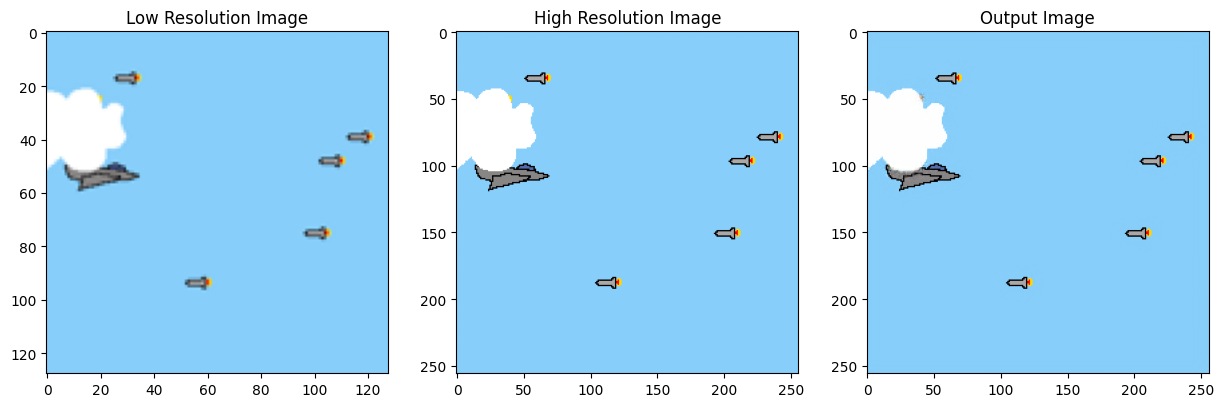

Epoch [701/2000], LR: 0.00096, Loss: 1.1084677680628374e-05
Epoch [702/2000], LR: 0.00096, Loss: 2.928865433204919e-05
Epoch [703/2000], LR: 0.00096, Loss: 4.353922849986702e-05
Epoch [704/2000], LR: 0.00096, Loss: 1.7293727069045417e-05
Epoch [705/2000], LR: 0.00096, Loss: 2.3439188225893304e-05
Epoch [706/2000], LR: 0.00096, Loss: 1.3346142623049673e-05
Epoch [707/2000], LR: 0.00096, Loss: 2.3421398509526625e-05
Epoch [708/2000], LR: 0.00096, Loss: 9.803758075577207e-06
Epoch [709/2000], LR: 0.00096, Loss: 2.8003165425616316e-05
Epoch [710/2000], LR: 0.00096, Loss: 1.11525077954866e-05
Epoch [711/2000], LR: 0.00096, Loss: 1.522350066807121e-05
Epoch [712/2000], LR: 0.00096, Loss: 1.325092489423696e-05
Epoch [713/2000], LR: 0.00096, Loss: 3.4393626265227795e-05
Epoch [714/2000], LR: 0.00096, Loss: 1.0490933163964655e-05
Epoch [715/2000], LR: 0.00096, Loss: 1.2259199138497934e-05
Epoch [716/2000], LR: 0.00096, Loss: 3.28396272379905e-05
Epoch [717/2000], LR: 0.00096, Loss: 3.4791555663

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [800/2000], LR: 0.00096, Loss: 1.8821938283508644e-05


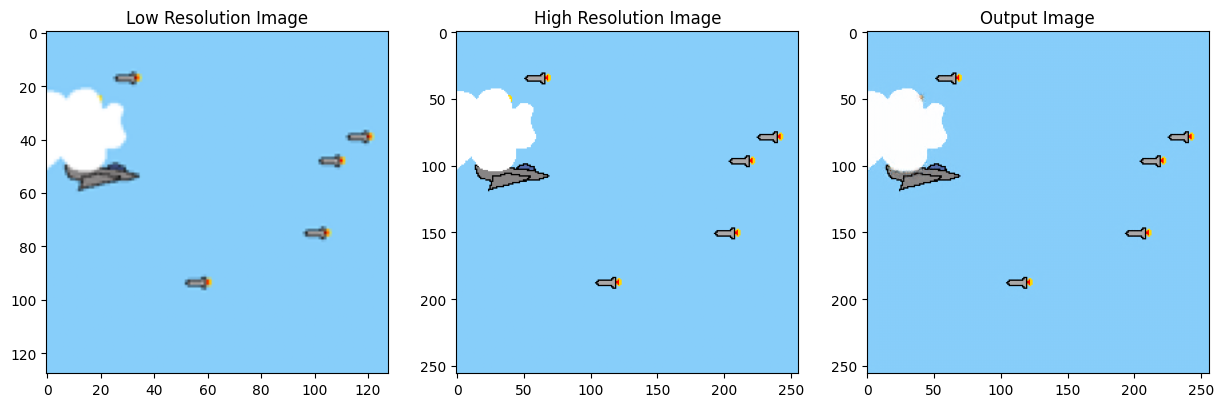

Epoch [801/2000], LR: 0.00096, Loss: 2.519505324016791e-05
Epoch [802/2000], LR: 0.00096, Loss: 2.3888758732937276e-05
Epoch [803/2000], LR: 0.00096, Loss: 1.552532921778038e-05
Epoch [804/2000], LR: 0.00096, Loss: 1.6481713828397915e-05
Epoch [805/2000], LR: 0.00096, Loss: 1.625361983315088e-05
Epoch [806/2000], LR: 0.00096, Loss: 8.539324880985077e-06
Epoch [807/2000], LR: 0.00096, Loss: 2.6937324946629815e-05
Epoch [808/2000], LR: 0.00096, Loss: 2.2006634026183747e-05
Epoch [809/2000], LR: 0.00096, Loss: 1.8461236322764307e-05
Epoch [810/2000], LR: 0.00096, Loss: 3.014318281202577e-05
Epoch [811/2000], LR: 0.00096, Loss: 1.1776773135352414e-05
Epoch [812/2000], LR: 0.00096, Loss: 1.533913382445462e-05
Epoch [813/2000], LR: 0.00096, Loss: 1.6439873434137553e-05
Epoch [814/2000], LR: 0.00096, Loss: 9.938785296981223e-06
Epoch [815/2000], LR: 0.00096, Loss: 1.4333555554912891e-05
Epoch [816/2000], LR: 0.00096, Loss: 2.5269317120546475e-05
Epoch [817/2000], LR: 0.00096, Loss: 1.90751125

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [900/2000], LR: 0.00096, Loss: 1.7922902770806104e-05


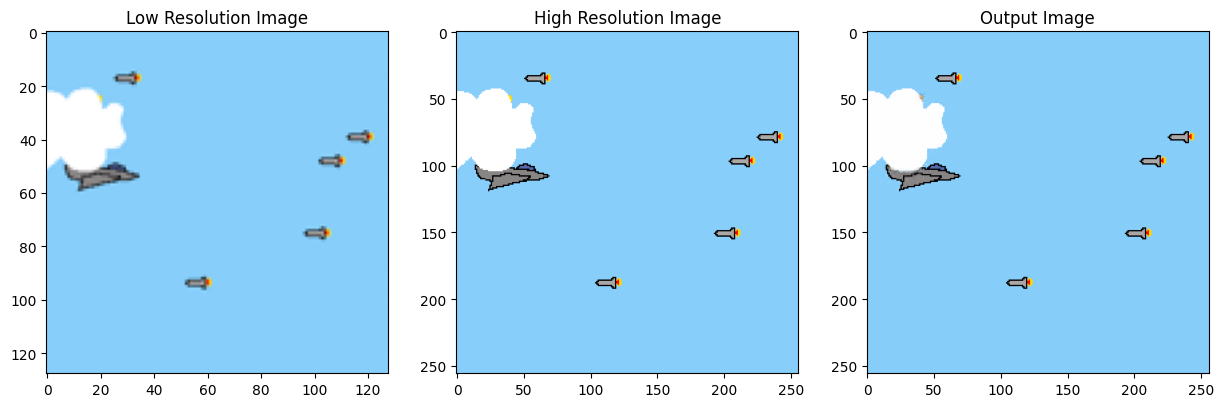

Epoch [901/2000], LR: 0.00096, Loss: 1.9429067833698355e-05
Epoch [902/2000], LR: 0.00096, Loss: 2.2985032046562992e-05
Epoch [903/2000], LR: 0.00096, Loss: 8.341109605680685e-06
Epoch [904/2000], LR: 0.00096, Loss: 1.3496562132786494e-05
Epoch [905/2000], LR: 0.00096, Loss: 6.364964974636678e-06
Epoch [906/2000], LR: 0.00096, Loss: 7.730209290457424e-06
Epoch [907/2000], LR: 0.00096, Loss: 1.7079491954063997e-05
Epoch [908/2000], LR: 0.00096, Loss: 2.07673801924102e-05
Epoch [909/2000], LR: 0.00096, Loss: 7.933373126434162e-06
Epoch [910/2000], LR: 0.00096, Loss: 1.3861112165614031e-05
Epoch [911/2000], LR: 0.00096, Loss: 1.1612641173996963e-05
Epoch [912/2000], LR: 0.00096, Loss: 8.893466656445526e-06
Epoch [913/2000], LR: 0.00096, Loss: 1.958761458809022e-05
Epoch [914/2000], LR: 0.00096, Loss: 1.8802813428919762e-05
Epoch [915/2000], LR: 0.00096, Loss: 1.9398472431930713e-05
Epoch [916/2000], LR: 0.00096, Loss: 2.917627352871932e-05
Epoch [917/2000], LR: 0.00096, Loss: 1.6693593352

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1000/2000], LR: 0.00096, Loss: 3.479348015389405e-05


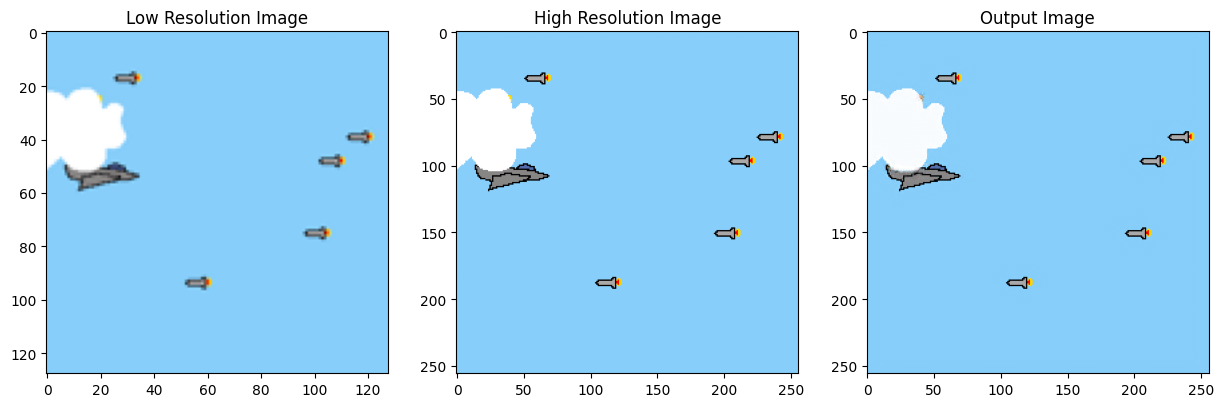

Epoch [1001/2000], LR: 0.0009216, Loss: 2.218038571299985e-05
Epoch [1002/2000], LR: 0.0009216, Loss: 2.771360414044466e-05
Epoch [1003/2000], LR: 0.0009216, Loss: 5.90062791161472e-06
Epoch [1004/2000], LR: 0.0009216, Loss: 2.4554223273298703e-05
Epoch [1005/2000], LR: 0.0009216, Loss: 1.93062805919908e-05
Epoch [1006/2000], LR: 0.0009216, Loss: 1.5286237612599507e-05
Epoch [1007/2000], LR: 0.0009216, Loss: 4.761884611070855e-06
Epoch [1008/2000], LR: 0.0009216, Loss: 9.131807928497437e-06
Epoch [1009/2000], LR: 0.0009216, Loss: 1.7854199541034177e-05
Epoch [1010/2000], LR: 0.0009216, Loss: 8.409776455664542e-06
Epoch [1011/2000], LR: 0.0009216, Loss: 1.6908979887375608e-05
Epoch [1012/2000], LR: 0.0009216, Loss: 2.766047509794589e-05
Epoch [1013/2000], LR: 0.0009216, Loss: 1.388797136314679e-05
Epoch [1014/2000], LR: 0.0009216, Loss: 2.9984357752255164e-05
Epoch [1015/2000], LR: 0.0009216, Loss: 1.5295419871108606e-05
Epoch [1016/2000], LR: 0.0009216, Loss: 3.163291694363579e-05
Epoc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1100/2000], LR: 0.0009216, Loss: 2.831842539308127e-05


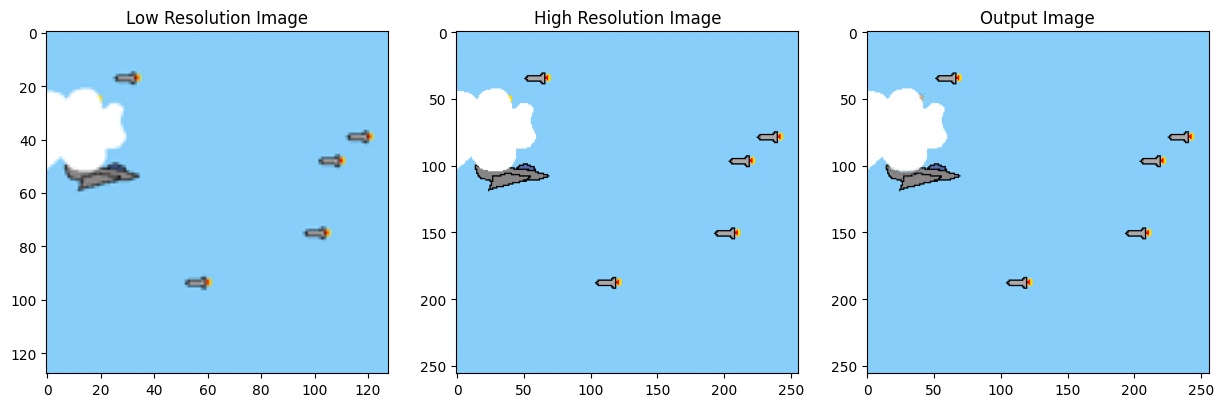

Epoch [1101/2000], LR: 0.0009216, Loss: 1.8838200048776343e-05
Epoch [1102/2000], LR: 0.0009216, Loss: 1.2830862033297308e-05
Epoch [1103/2000], LR: 0.0009216, Loss: 2.0275379938539118e-05
Epoch [1104/2000], LR: 0.0009216, Loss: 8.86751149664633e-06
Epoch [1105/2000], LR: 0.0009216, Loss: 2.8552378353197128e-05
Epoch [1106/2000], LR: 0.0009216, Loss: 1.6910624253796414e-05
Epoch [1107/2000], LR: 0.0009216, Loss: 8.439104931312613e-06
Epoch [1108/2000], LR: 0.0009216, Loss: 8.996890755952336e-06
Epoch [1109/2000], LR: 0.0009216, Loss: 3.034403925994411e-05
Epoch [1110/2000], LR: 0.0009216, Loss: 1.567586514283903e-05
Epoch [1111/2000], LR: 0.0009216, Loss: 2.6085326680913568e-05
Epoch [1112/2000], LR: 0.0009216, Loss: 2.9481894671334885e-05
Epoch [1113/2000], LR: 0.0009216, Loss: 2.3319036699831486e-05
Epoch [1114/2000], LR: 0.0009216, Loss: 1.827450978453271e-05
Epoch [1115/2000], LR: 0.0009216, Loss: 1.0800405107147526e-05
Epoch [1116/2000], LR: 0.0009216, Loss: 6.124110768723767e-06


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1200/2000], LR: 0.0009216, Loss: 8.274004358099774e-06


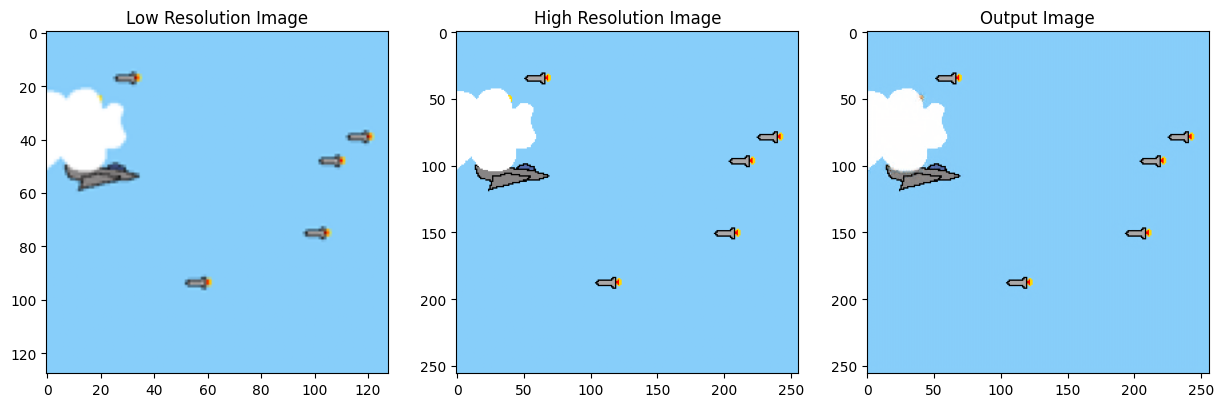

Epoch [1201/2000], LR: 0.0009216, Loss: 1.2612541468115523e-05
Epoch [1202/2000], LR: 0.0009216, Loss: 8.492215783917345e-06
Epoch [1203/2000], LR: 0.0009216, Loss: 2.404084625595715e-05
Epoch [1204/2000], LR: 0.0009216, Loss: 6.8558292696252465e-06
Epoch [1205/2000], LR: 0.0009216, Loss: 1.903675183712039e-05
Epoch [1206/2000], LR: 0.0009216, Loss: 5.6084568313963246e-06
Epoch [1207/2000], LR: 0.0009216, Loss: 6.6857073761639185e-06
Epoch [1208/2000], LR: 0.0009216, Loss: 1.1627328603935894e-05
Epoch [1209/2000], LR: 0.0009216, Loss: 9.253525604435708e-06
Epoch [1210/2000], LR: 0.0009216, Loss: 7.446345989592373e-06
Epoch [1211/2000], LR: 0.0009216, Loss: 1.8766157154459506e-05
Epoch [1212/2000], LR: 0.0009216, Loss: 1.5414416338899173e-05
Epoch [1213/2000], LR: 0.0009216, Loss: 7.874650691519491e-06
Epoch [1214/2000], LR: 0.0009216, Loss: 1.2528073966677766e-05
Epoch [1215/2000], LR: 0.0009216, Loss: 6.166888397274306e-06
Epoch [1216/2000], LR: 0.0009216, Loss: 2.4145854695234448e-05

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1300/2000], LR: 0.0009216, Loss: 1.6670735931256786e-05


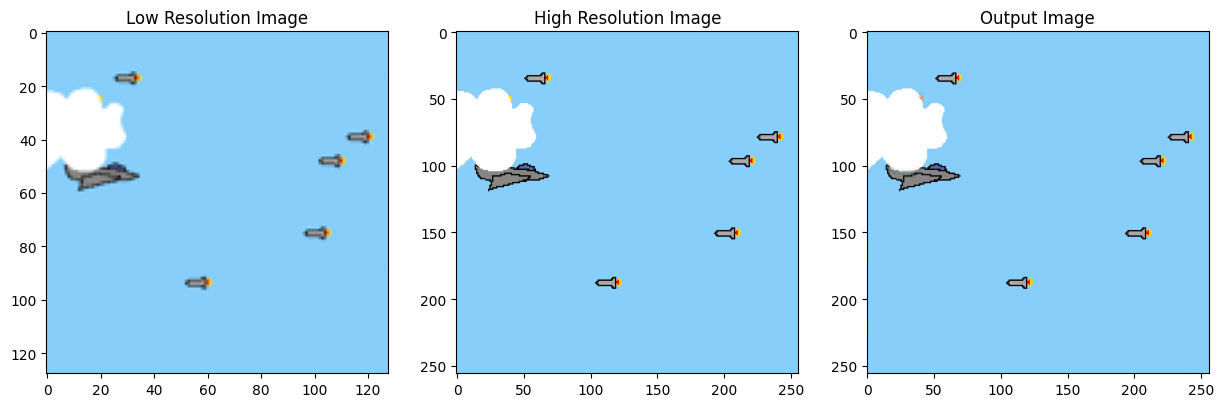

Epoch [1301/2000], LR: 0.0009216, Loss: 1.3293089068611152e-05
Epoch [1302/2000], LR: 0.0009216, Loss: 1.3073683476250153e-05
Epoch [1303/2000], LR: 0.0009216, Loss: 2.3366694222204387e-05
Epoch [1304/2000], LR: 0.0009216, Loss: 2.32001330005005e-05
Epoch [1305/2000], LR: 0.0009216, Loss: 1.291056105401367e-05
Epoch [1306/2000], LR: 0.0009216, Loss: 1.3933327863924205e-05
Epoch [1307/2000], LR: 0.0009216, Loss: 1.1665028978313785e-05
Epoch [1308/2000], LR: 0.0009216, Loss: 1.4731965165992733e-05
Epoch [1309/2000], LR: 0.0009216, Loss: 1.144338875747053e-05
Epoch [1310/2000], LR: 0.0009216, Loss: 2.4762795874266885e-05
Epoch [1311/2000], LR: 0.0009216, Loss: 6.7032269726041704e-06
Epoch [1312/2000], LR: 0.0009216, Loss: 1.3143107935320586e-05
Epoch [1313/2000], LR: 0.0009216, Loss: 1.6182722902158275e-05
Epoch [1314/2000], LR: 0.0009216, Loss: 2.069034962914884e-05
Epoch [1315/2000], LR: 0.0009216, Loss: 1.647266253712587e-05
Epoch [1316/2000], LR: 0.0009216, Loss: 8.330682248924859e-06

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1400/2000], LR: 0.0009216, Loss: 1.0685003871913068e-05


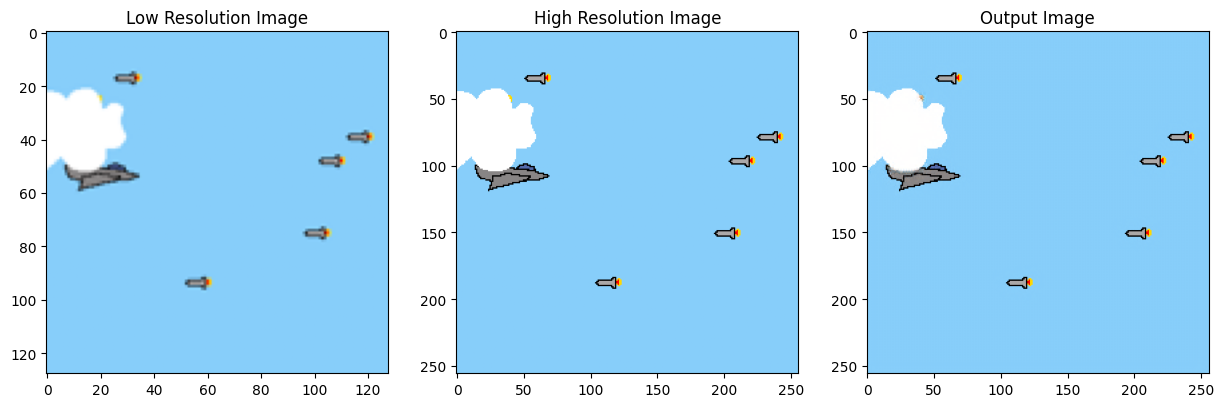

Epoch [1401/2000], LR: 0.0009216, Loss: 1.9508745026541874e-05
Epoch [1402/2000], LR: 0.0009216, Loss: 1.67482048709644e-05
Epoch [1403/2000], LR: 0.0009216, Loss: 1.7971095076063648e-05
Epoch [1404/2000], LR: 0.0009216, Loss: 4.832867944060126e-06
Epoch [1405/2000], LR: 0.0009216, Loss: 1.666472599026747e-05
Epoch [1406/2000], LR: 0.0009216, Loss: 1.5675061149522662e-05
Epoch [1407/2000], LR: 0.0009216, Loss: 1.2289557162148412e-05
Epoch [1408/2000], LR: 0.0009216, Loss: 1.5848010662011802e-05
Epoch [1409/2000], LR: 0.0009216, Loss: 1.0289927558915224e-05
Epoch [1410/2000], LR: 0.0009216, Loss: 1.4232560715754516e-05
Epoch [1411/2000], LR: 0.0009216, Loss: 6.56507836538367e-06
Epoch [1412/2000], LR: 0.0009216, Loss: 2.3475940906791948e-05
Epoch [1413/2000], LR: 0.0009216, Loss: 7.3815754149109125e-06
Epoch [1414/2000], LR: 0.0009216, Loss: 8.082653039309662e-06
Epoch [1415/2000], LR: 0.0009216, Loss: 1.320130832027644e-05
Epoch [1416/2000], LR: 0.0009216, Loss: 2.5441502657486126e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1500/2000], LR: 0.0009216, Loss: 6.1075197663740255e-06


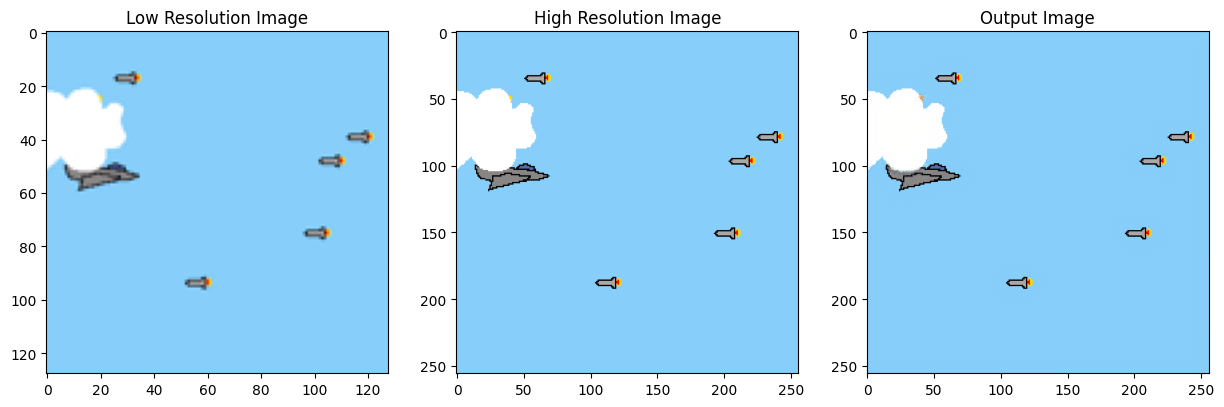

Epoch [1501/2000], LR: 0.0008847359999999999, Loss: 3.5828670661430806e-05
Epoch [1502/2000], LR: 0.0008847359999999999, Loss: 1.3071576177026145e-05
Epoch [1503/2000], LR: 0.0008847359999999999, Loss: 1.6799711374915205e-05
Epoch [1504/2000], LR: 0.0008847359999999999, Loss: 1.0311915502825286e-05
Epoch [1505/2000], LR: 0.0008847359999999999, Loss: 2.9359187465161085e-05
Epoch [1506/2000], LR: 0.0008847359999999999, Loss: 8.186943887267262e-06
Epoch [1507/2000], LR: 0.0008847359999999999, Loss: 7.001400717854267e-06
Epoch [1508/2000], LR: 0.0008847359999999999, Loss: 2.557927291491069e-05
Epoch [1509/2000], LR: 0.0008847359999999999, Loss: 6.277412467170507e-06
Epoch [1510/2000], LR: 0.0008847359999999999, Loss: 1.5186428754532244e-05
Epoch [1511/2000], LR: 0.0008847359999999999, Loss: 1.7659640434430912e-05
Epoch [1512/2000], LR: 0.0008847359999999999, Loss: 1.376720319967717e-05
Epoch [1513/2000], LR: 0.0008847359999999999, Loss: 6.179801857797429e-06
Epoch [1514/2000], LR: 0.000884

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1600/2000], LR: 0.0008847359999999999, Loss: 4.331413038016763e-06


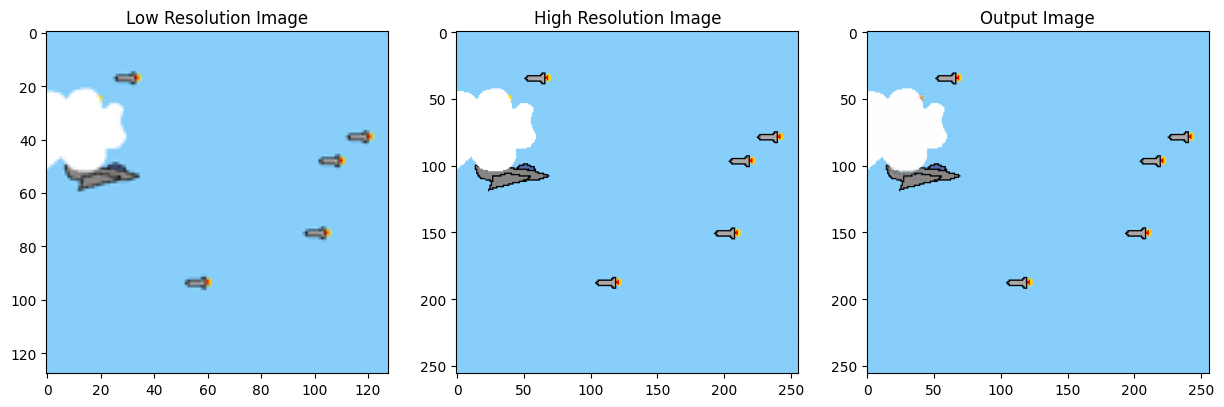

Epoch [1601/2000], LR: 0.0008847359999999999, Loss: 1.4726810150023084e-05
Epoch [1602/2000], LR: 0.0008847359999999999, Loss: 1.0138363904843573e-05
Epoch [1603/2000], LR: 0.0008847359999999999, Loss: 1.4657103747595102e-05
Epoch [1604/2000], LR: 0.0008847359999999999, Loss: 1.039542166836327e-05
Epoch [1605/2000], LR: 0.0008847359999999999, Loss: 9.361115189676639e-06
Epoch [1606/2000], LR: 0.0008847359999999999, Loss: 8.545624041289557e-06
Epoch [1607/2000], LR: 0.0008847359999999999, Loss: 1.556934330437798e-05
Epoch [1608/2000], LR: 0.0008847359999999999, Loss: 2.4134669729392044e-05
Epoch [1609/2000], LR: 0.0008847359999999999, Loss: 1.237519427377265e-05
Epoch [1610/2000], LR: 0.0008847359999999999, Loss: 9.541554391034879e-06
Epoch [1611/2000], LR: 0.0008847359999999999, Loss: 1.8293991161044687e-05
Epoch [1612/2000], LR: 0.0008847359999999999, Loss: 1.3867376765119843e-05
Epoch [1613/2000], LR: 0.0008847359999999999, Loss: 1.3436681001621764e-05
Epoch [1614/2000], LR: 0.000884

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1700/2000], LR: 0.0008847359999999999, Loss: 4.157408693572506e-05


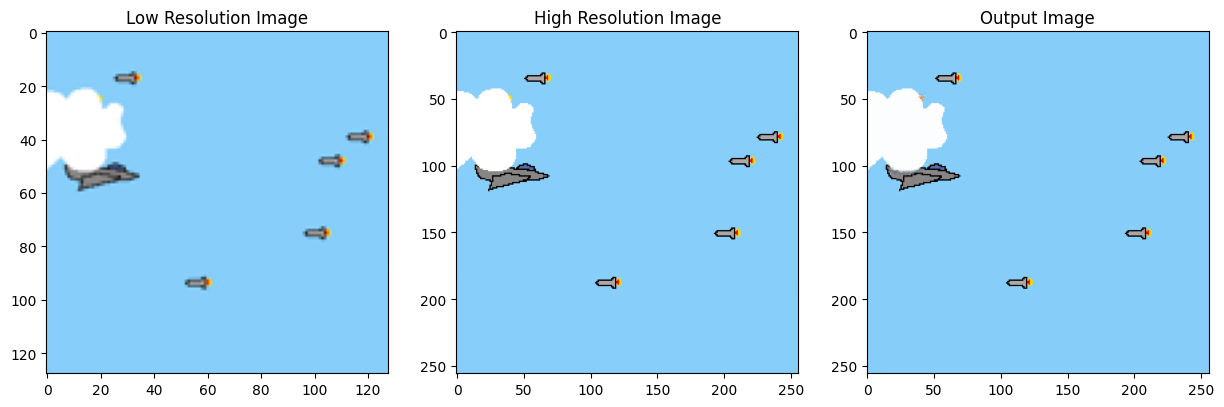

Epoch [1701/2000], LR: 0.0008847359999999999, Loss: 1.966139825526625e-05
Epoch [1702/2000], LR: 0.0008847359999999999, Loss: 1.4432497664529365e-05
Epoch [1703/2000], LR: 0.0008847359999999999, Loss: 3.3952048397623e-05
Epoch [1704/2000], LR: 0.0008847359999999999, Loss: 5.8241193983121775e-06
Epoch [1705/2000], LR: 0.0008847359999999999, Loss: 1.4542386452376377e-05
Epoch [1706/2000], LR: 0.0008847359999999999, Loss: 2.333070369786583e-05
Epoch [1707/2000], LR: 0.0008847359999999999, Loss: 1.771310780895874e-05
Epoch [1708/2000], LR: 0.0008847359999999999, Loss: 1.5991638065315783e-05
Epoch [1709/2000], LR: 0.0008847359999999999, Loss: 1.0623290108924266e-05
Epoch [1710/2000], LR: 0.0008847359999999999, Loss: 1.9260711269453168e-05
Epoch [1711/2000], LR: 0.0008847359999999999, Loss: 1.1553383046702947e-05
Epoch [1712/2000], LR: 0.0008847359999999999, Loss: 1.0756091796793044e-05
Epoch [1713/2000], LR: 0.0008847359999999999, Loss: 1.983756919798907e-05
Epoch [1714/2000], LR: 0.0008847

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1800/2000], LR: 0.0008847359999999999, Loss: 1.8613740394357592e-05


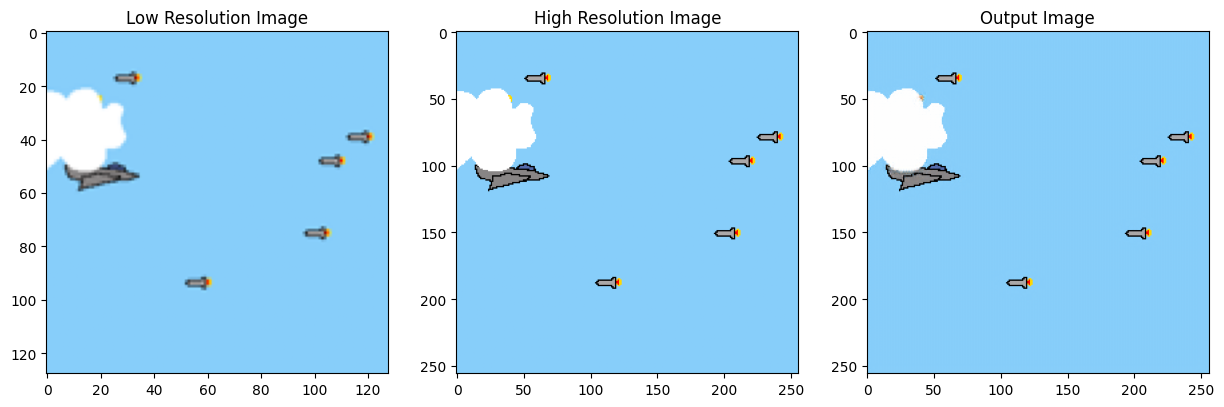

Epoch [1801/2000], LR: 0.0008847359999999999, Loss: 1.3084416423225775e-05
Epoch [1802/2000], LR: 0.0008847359999999999, Loss: 2.4287050109705888e-05
Epoch [1803/2000], LR: 0.0008847359999999999, Loss: 1.6060193956946023e-05
Epoch [1804/2000], LR: 0.0008847359999999999, Loss: 7.948821803438477e-06
Epoch [1805/2000], LR: 0.0008847359999999999, Loss: 1.712943776510656e-05
Epoch [1806/2000], LR: 0.0008847359999999999, Loss: 5.754922312917188e-06
Epoch [1807/2000], LR: 0.0008847359999999999, Loss: 1.1278612873866223e-05
Epoch [1808/2000], LR: 0.0008847359999999999, Loss: 6.325704362097895e-06
Epoch [1809/2000], LR: 0.0008847359999999999, Loss: 1.2651867109525483e-05
Epoch [1810/2000], LR: 0.0008847359999999999, Loss: 1.1639136573649012e-05
Epoch [1811/2000], LR: 0.0008847359999999999, Loss: 1.3872911040380131e-05
Epoch [1812/2000], LR: 0.0008847359999999999, Loss: 1.3386673344939481e-05
Epoch [1813/2000], LR: 0.0008847359999999999, Loss: 4.712180270871613e-06
Epoch [1814/2000], LR: 0.00088

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1900/2000], LR: 0.0008847359999999999, Loss: 2.0927558580297045e-05


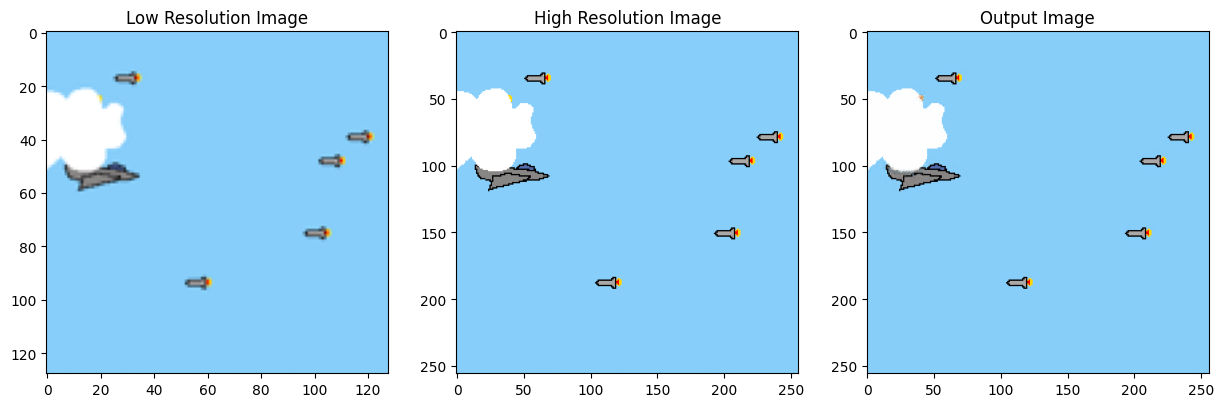

Epoch [1901/2000], LR: 0.0008847359999999999, Loss: 1.487048120907275e-05
Epoch [1902/2000], LR: 0.0008847359999999999, Loss: 1.3787232091999613e-05
Epoch [1903/2000], LR: 0.0008847359999999999, Loss: 1.163621163868811e-05
Epoch [1904/2000], LR: 0.0008847359999999999, Loss: 1.5085290215210989e-05
Epoch [1905/2000], LR: 0.0008847359999999999, Loss: 4.704718776338268e-06
Epoch [1906/2000], LR: 0.0008847359999999999, Loss: 2.0139492335147224e-05
Epoch [1907/2000], LR: 0.0008847359999999999, Loss: 9.6551411843393e-06
Epoch [1908/2000], LR: 0.0008847359999999999, Loss: 2.2841184545541182e-05
Epoch [1909/2000], LR: 0.0008847359999999999, Loss: 5.445206625154242e-06
Epoch [1910/2000], LR: 0.0008847359999999999, Loss: 1.1221210115763824e-05
Epoch [1911/2000], LR: 0.0008847359999999999, Loss: 1.1275059478066396e-05
Epoch [1912/2000], LR: 0.0008847359999999999, Loss: 1.8914755855803378e-05
Epoch [1913/2000], LR: 0.0008847359999999999, Loss: 2.0291798136895522e-05
Epoch [1914/2000], LR: 0.0008847

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [2000/2000], LR: 0.0008847359999999999, Loss: 2.1900526917306706e-05


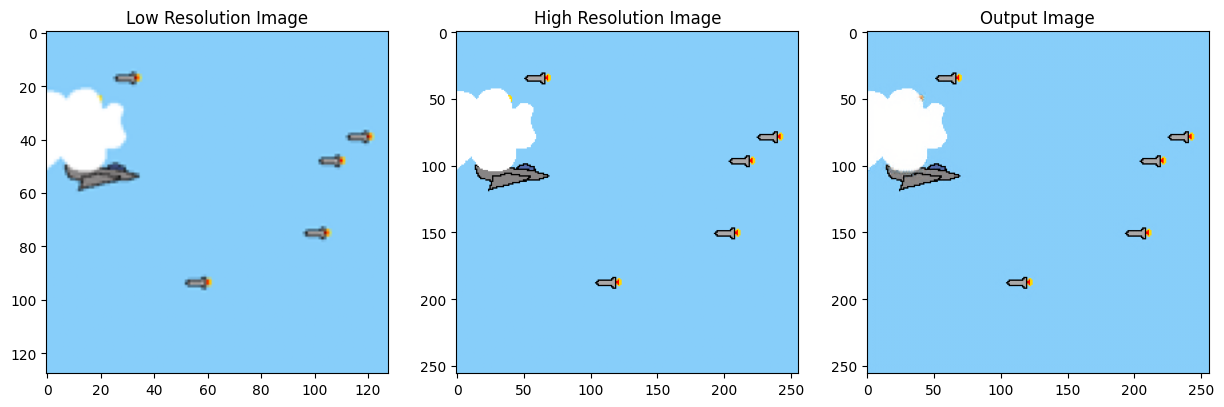

Finished Training


In [12]:
# Training loop
for epoch in range(num_epochs):
    for i, (lr_batch, hr_batch) in enumerate(dataloader):
        # Move the batches to the GPU
        lr_batch = lr_batch.to(device)
        hr_batch = hr_batch.to(device)
        
        # Forward pass
        outputs = model(lr_batch)
        loss = criterion(outputs, hr_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the loss
        losses.append(loss.item())

    lr = optimizer.param_groups[0]["lr"]
    print(f'Epoch [{epoch+1}/{num_epochs}], LR: {lr}, Loss: {loss.item()}')
    scheduler.step()

    if (epoch+1) % 100 == 0 or (epoch+1) == 1:
        show_images(index)
        torch.save(model.state_dict(), f'{epoch+1}_model_save.pth')
    if epoch > 1500 and loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), f'250224_best_model.pth')

print('Finished Training')

In [13]:
print(f'The best loss was: {best_loss}')

The best loss was: 3.612352884374559e-06


My best (lowest wins!): 3.612352884374559e-06

Plot a graph of the losses over time

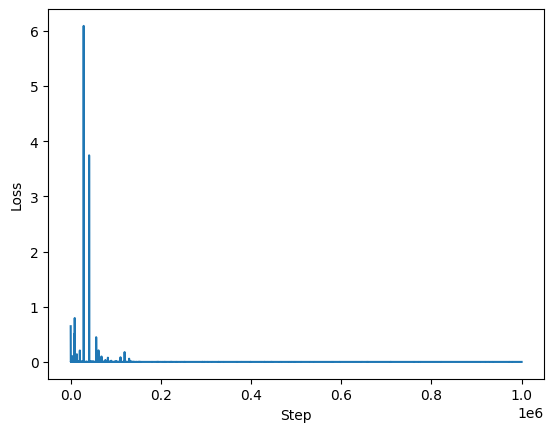

In [14]:
# Plot the losses
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

Zoom into this graph a little

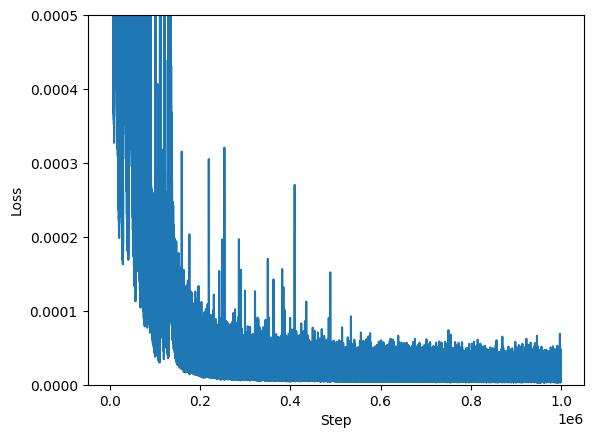

In [21]:
# Plot the losses
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.ylim(0, 0.0005)
plt.show()

Save all of these values in a csv to allow for any further investigation

In [22]:
with open('losses.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for loss in losses:
        writer.writerow([loss])

Display the final output from the model and compare it to the low and high resolution equivalents. You can change the index value to change the images to display

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


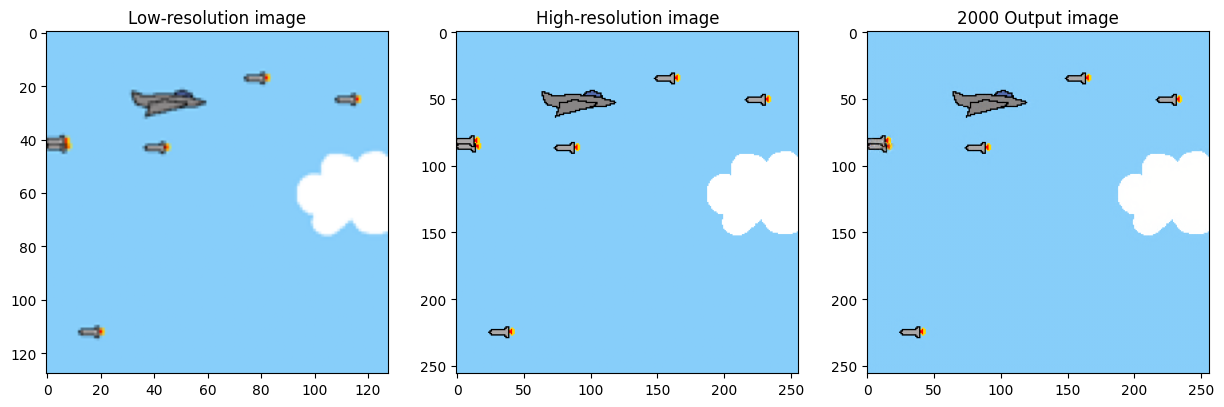

In [23]:
index = 2

# Select an image from the low-resolution dataset
low_res_image, high_res_image = dataset[index]  # Change the index to select a different image

# Move the images to the GPU and add an extra dimension for the batch size
low_res_image = low_res_image.unsqueeze(0).to(device)
high_res_image = high_res_image.unsqueeze(0).to(device)

# Make a prediction with the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Don't compute gradients
    output = model(low_res_image)

# Move the images back to the CPU and remove the extra dimension
low_res_image = low_res_image.squeeze(0).cpu()
high_res_image = high_res_image.squeeze(0).cpu()
output = output.squeeze(0).cpu()

# Convert the images from PyTorch tensors to numpy arrays
low_res_image = low_res_image.permute(1, 2, 0).numpy()
high_res_image = high_res_image.permute(1, 2, 0).numpy()
output = output.permute(1, 2, 0).numpy()

# Display the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(low_res_image)
plt.title(f'Low-resolution image')
plt.subplot(1, 3, 2)
plt.imshow(high_res_image)
plt.title(f'High-resolution image')
plt.subplot(1, 3, 3)
plt.imshow(output)
plt.title(f'{num_epochs} Output image')
plt.show()

Save the output image if you wanted

In [18]:
# Clip the values in the images to be within the range of 0 to 1
low_res_image = np.clip(low_res_image, 0, 1)
high_res_image = np.clip(high_res_image, 0, 1)
output = np.clip(output, 0, 1)

# Save the images
# plt.imsave(f'low_res_image.png', low_res_image)
# plt.imsave(f'high_res_image.png', high_res_image)
plt.imsave(f'output.png', output)